![Curso de Visión Artificial](imagenes/encabezado.png)




# Extracción de Características

La etapa de extracción de características consiste en calcular un **vector de características** que contenga ciertas medidas o métricas sobre cada uno de los objetos de la imagen. Dichas características son empleadas, más adelante, para entrenar un clasificador que diferencia entre clases de objetos.
 
En este caso utilizaremos el paquete `measure` de `Skimage` cuya documentación se encuentra disponible [aquí](http://scikit-image.org/docs/stable/api/skimage.measure.html).
 
Veamos como extraer características BÁSICAS de los objetos en `Skimage`.

In [1]:
# Siempre que usemos matplotlib en Jupyter es necesario poner esta línea antes de cualquier otra
%matplotlib inline

# Importamos las bibliotecas necesarias y les asignamos un alias
import skimage                           # Biblioteca para la manipulación de imágenes
import numpy as np                       # Biblioteca para la manipulación de matrices

# Importamos algunos paquetes específicos
from matplotlib import pyplot as plt     # Biblioteca para crear gráficas y mostrar las imágenes en pantalla

from skimage import data                 # Paquete con imágenes de prueba
from skimage import io                   # Paquete para lectura/escritura de imágenes
from skimage import color                # Paquete con las operaciones de transformaciones entre espacios de color
from skimage import exposure             # Paquete con las funciones para calcular y alterar el histograma
from skimage import filters              # Paquete que contiene las máscaras y filtros de suavizado y realzado
from skimage import util                 # Paquete que contiene las funciones para cambiar el tipo de dato de las imágenes
from skimage import morphology           # Para crear el kernel de convolución en los filtros no lienales
from skimage import transform            # Esta biblioteca es la que contiene la implementación de Hough
from skimage import measure              # Esta biblioteca contiene el método de etiquetado de regiones
from skimage import feature              # Esta biblioteca es la que contiene la implementación del canny

from scipy import ndimage                # Usamos esta biblioteca para realizar la operación de convolución
import skdemo                            # Paquete ESPECIAL ADJUNTO con algunas funciones extra de visualización

###########################

from scipy.stats import kde              # Esta biblioteca es necesaria para estimar la función de densidad de los datos
from sklearn import preprocessing        # Este paquete contiene las funciones de preprocesamiento de datos
from sklearn import feature_selection    # Este paquete contiene los métodos de selección de características de sklearn
from sklearn import svm                  # Este paquete contiene las funciones de un clasificador SVM
from sklearn import model_selection      # Este paquete contiene las funciones de particionamiento de datos y validación cruzada
from sklearn import metrics              # Este paquete contiene las funciones para evaluar un clasificador

# Con este nos aseguramos que las imágenes en niveles de gris, se vean como tal siempre.
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

## Problema: clasificación de flechas

La idea con este ejercicio de la práctica es diseñar un clasificador automático de flechas que, por ejemplo, puede ser usado para identificación de señales de tránsito.

Para ello se proveen dos imágenes, una que tiene los objetos (flechas) para entrenar un clasificador y otra imagen que contiene los objetos de prueba. Cada una de las imágenes contiene 3 tipos de flechas, como las que se muestra a continuación.

![Flechas de Muestra](imagenes/FlechasMuestra.png)

Antes que nada, debemos cargar las dos imágenes que contienen nuestros objetos de interés:


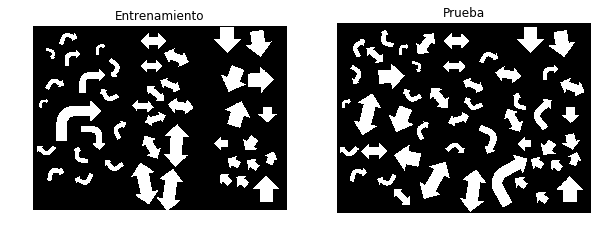

In [2]:
# Cargamos las imágenes
tr_img = io.imread("imagenes/flechas.bmp")
ts_img = io.imread("imagenes/flechastest.bmp")

# Como los objetos son negros y el fondo blanco, cambiamos la configuración de la imagen
tr_img = (tr_img < 128).astype("uint8")
ts_img = (ts_img < 128).astype("uint8")

# Mostramos las imágenes
skdemo.imshow_all(tr_img, ts_img, titles=["Entrenamiento", "Prueba"]);

## Calculando las características de los objetos
Empecemos extrayendo las características geométricas de una sola flecha. Ponga atención al siguiente código:

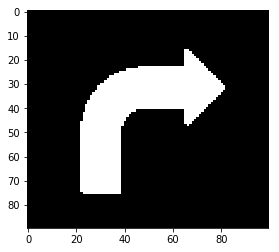

In [3]:
# Sacamos una de las flecas de la imagen
f = tr_img[80:170,100:200];
plt.imshow(f); 


In [4]:
# Calculamos las características básicas de esa flecha
props = measure.regionprops(f, coordinates='rc')
#props = measure.regionprops(f)

# Visualizamos algunas características de la flecha:
print("-----------------------------------\nAlgunas características calculadas:\n-----------------------------------")
print ("Area: ",props[0].area)
print ("Centroid: ",props[0].centroid)
print ("Eccentricity: ",props[0].eccentricity)
print ("Diameter: ",props[0].equivalent_diameter)


-----------------------------------
Algunas características calculadas:
-----------------------------------
Area:  1527
Centroid:  (42.23510150622135, 44.97576948264571)
Eccentricity:  0.8893232088736915
Diameter:  44.09350048261754


Por favor, consulte la documentación de la función <span style="background-color:#DDDDDD; color:blue; font-family:Courier new">measure.regionprops</span> para que lea que otras características extrae esta función.

Ahora vemos como extraer las características de todos los objetos en la imagen:

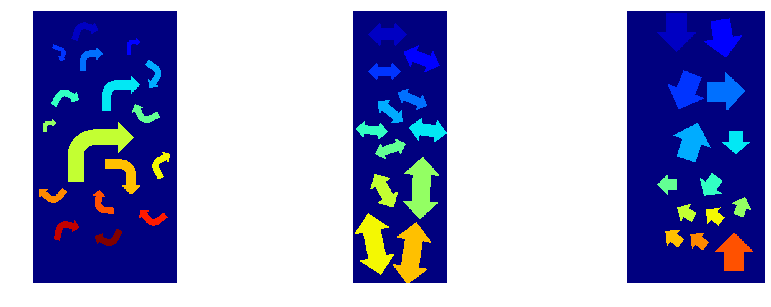

In [6]:
# Note que las flechas del mismo tipo están agrupadas en la imagen de entrenamiento
# Aplicamos el método de etiquetado de componentes conexas para identificar los píxeles que pertenecen a cada flecha
f1 = measure.label(tr_img[:, :375]) #Flechas unidireccionales curvas
f2 = measure.label(tr_img[:, 375:620]) #Flechas bidireccionales
f3 = measure.label(tr_img[:, 620:]) #Flechas unidireccionales rectas

# Visualizamos los objetos etiquetados
skdemo.imshow_all(f1, f2, f3, cmap="jet"); 


Ahora debemos asignar MANUALMENTE la etiqueta de clase de cada objeto en la imagen. Donde la clase 1 son las flechas unidireccionales curvas, la clase 2 son las flechas bidireccionales y la clase 3 son las flechas unidireccionales rectas.

In [9]:
#Se crea el vector de etiqueta de cada clase
y1 = np.full((f1.max(),1), 1) #Flechas unidireccionales curvas
y2 = np.full((f2.max(),1), 2) #Flechas bidireccionales
y3 = np.full((f3.max(),1), 3) #Flechas unidireccionales rectas

y = np.vstack([y1,y2,y3])
y = np.ravel(y)


Ahora vamos a extraer las características de forma de todas las flechas de cada tipo:

In [10]:
# Por cada grupo de flechas, se extraen las características de cada objeto en la imagen, es decir de cada flecha
props_f1 = measure.regionprops(f1, coordinates='rc')
props_f2 = measure.regionprops(f2, coordinates='rc')
props_f3 = measure.regionprops(f3, coordinates='rc')

#props_f1 = measure.regionprops(f1)
#props_f2 = measure.regionprops(f2)
#props_f3 = measure.regionprops(f3)

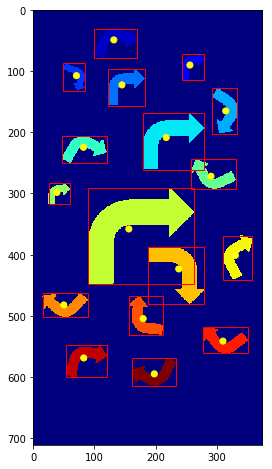

In [11]:
# SOLO a modo de ejemplo, mostremos en la imagen el rectángulo envolvente y el centroide de cada flecha en el grupo 1
from matplotlib.patches import Circle, Rectangle

plt.rcParams['figure.figsize'] = [10, 8]

fig, ax = plt.subplots()
ax.imshow(f1, cmap="jet")

# Muestre la caja envolvente de cada flecha y el centroide de las flechas tipo 1:
for region in props_f1:
    x1 = region.bbox[1] #Columna
    y1 = region.bbox[0] #Fila
    w = region.bbox[3] - region.bbox[1] #Ancho
    h = region.bbox[2] - region.bbox[0] #Alto
    rc = Rectangle((x1, y1), w, h, linewidth=1, edgecolor='red', fill=False)
    ax.add_artist(rc)
    
    c = Circle((region.centroid[1], region.centroid[0]), radius=5, linewidth=1, edgecolor='yellow', facecolor='yellow')
    ax.add_artist(c)

## Visualizando las características de forma individual

Una vez calculadas las características (en este caso las básicas de forma) procedemos a hacer un análisis de las mismas (lo que hicimos con las mandarinas). Para ello graficamos la distribución de cada característica de manera individual. En este caso mostremos la distribución del área por tipo de flecha.

En este caso nos toca agrupar todas las áreas de cada grupo de flechas en un vector:

In [13]:
# Obtenemos el área de todos los objetos en las 3 subimagenes
# La siguiente instrucción crea un arreglo [] en el que iterativamente (con el for) se van 
# agregando las áreas de cada flecha, la cual está en la lista de características props_f*
areas_f1 = [r.area for r in props_f1]
areas_f2 = [r.area for r in props_f2]
areas_f3 = [r.area for r in props_f3]

Procedemos a visualizar los valores del área entre los diferentes tipos de flechas. Esto lo podemos hacer usando histogramas, como se muestra a continuación.

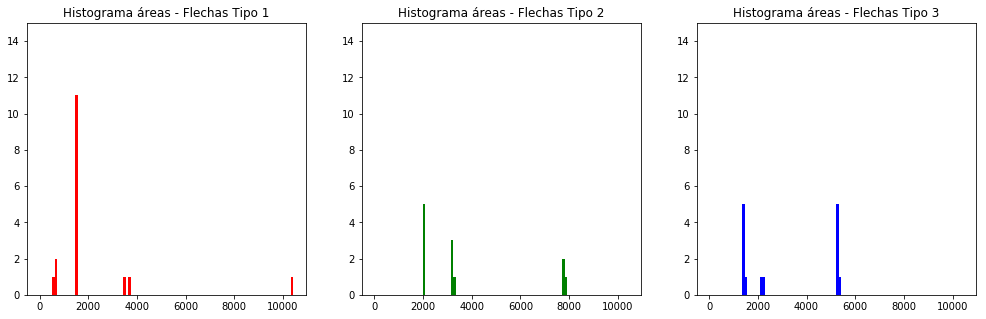

In [14]:
#Para iniciar concatenamos en un vector todas las áreas para obtener el valor máximo de las mismas
areas = np.hstack((areas_f1,areas_f2, areas_f3))
M = areas.max()

fig, ax = plt.subplots(1,3, figsize=[17,5])

# Una vez tenemos to]das las áreas en tres arreglos diferentes, creamos los histogramas, usando 100 grupos (o bins)
ax[0].hist(areas_f1, bins=100, range=(0, M), color="r")
ax[0].set_ylim(0, 15)
ax[0].set_title("Histograma áreas - Flechas Tipo 1")

ax[1].hist(areas_f2, bins=100, range=(0, M), color="g")
ax[1].set_title("Histograma áreas - Flechas Tipo 2")
ax[1].set_ylim(0, 15)

ax[2].hist(areas_f3, bins=100, range=(0, M), color="b")
ax[2].set_ylim(0, 15)
ax[2].set_title("Histograma áreas - Flechas Tipo 3")
plt.show()

Otra forma para determinar si la característica es buena o no es visualizar la función de densidad de la variable (estadística), la cual se puede estimar usando KDE (kernel density estimation). A continuación, se muestra un ejemplo.

Text(0.5, 0, 'Área')

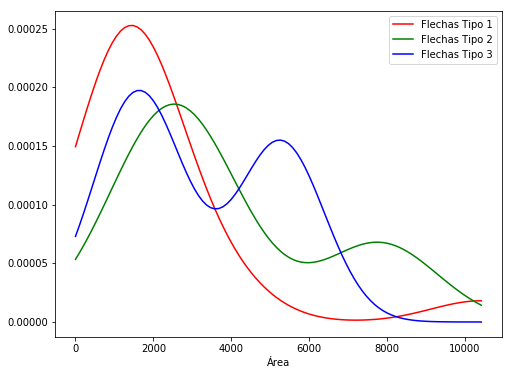

In [15]:
plt.figure(figsize=[8,6])

#Estimamos la función densidad del área en cada uno de los tipos de flechas
kde1 = kde.gaussian_kde( areas_f1 )
kde2 = kde.gaussian_kde( areas_f2 )
kde3 = kde.gaussian_kde( areas_f3 )

#Graficamos, usando el valor máximo de las áreas de referencia
dist_space = np.linspace( 0, M, 100 )
plt.plot( dist_space, kde1(dist_space), color = "r", label="a")
plt.plot( dist_space, kde2(dist_space), color = "g")
plt.plot( dist_space, kde3(dist_space), color = "b")

plt.legend(('Flechas Tipo 1', 'Flechas Tipo 2', 'Flechas Tipo 3'), loc='upper right')
plt.xlabel('Área')

Tenga presente que esto lo podemos hacer porque tenemos pocos objetos (hay máximo 16 flechas de cada tipo). Sin embargo, cuando hay muchos objetos, por ejemplo, 100 objetos por clase, se debe crear un histograma para la característica.

¿Es el área de las flechas una buena característica?

R/=

Text(0.5, 0, 'Eccentricity')

<Figure size 720x576 with 0 Axes>

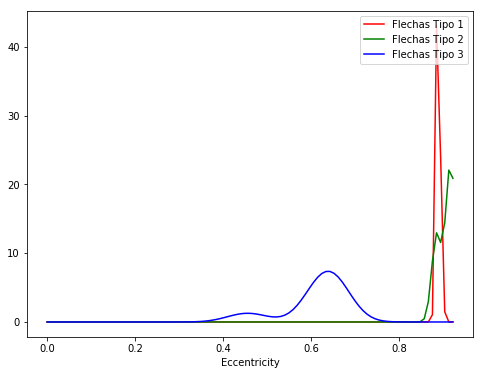

In [16]:
# Obtenemos la excentricidad
ecc1 = [r.eccentricity for r in props_f1]
ecc2 = [r.eccentricity for r in props_f2]
ecc3 = [r.eccentricity for r in props_f3]

eccs = np.hstack((ecc1, ecc2, ecc3))
M = max(eccs)

#Visualizamos la excentricidad de los objetos
plt.figure(figsize=[10,8])

#Estimamos la función densidad
kde1 = kde.gaussian_kde( ecc1 )
kde2 = kde.gaussian_kde( ecc2 )
kde3 = kde.gaussian_kde( ecc3 )

#Graficamos, usando el valor máximo de las áreas de referencia
dist_space = np.linspace( 0, M, 100 )
plt.figure(figsize=[8,6])
plt.plot( dist_space, kde1(dist_space), color = "r")
plt.plot( dist_space, kde2(dist_space), color = "g")
plt.plot( dist_space, kde3(dist_space), color = "b")

plt.legend(('Flechas Tipo 1', 'Flechas Tipo 2', 'Flechas Tipo 3'), loc='upper right')
plt.xlabel('Eccentricity')

¿Es la excentricidad de las flechas una buena característica?

R/=

## Visualización del espacio de dos características
Escoja de a 2 características para graficar la distribución de las clases y encuentre una combinación que muestre 
una buena separabilidad. En este ejemplo se muestra la distribución para las características del area vs excentricidad.


<Figure size 864x720 with 0 Axes>

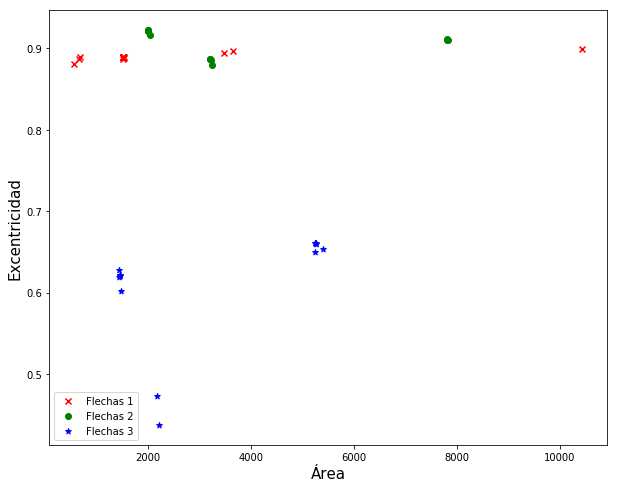

In [17]:
plt.figure(figsize=[12,10])
fig, ax = plt.subplots()
ax.scatter(areas_f1, ecc1, marker='x', color='r')
ax.scatter(areas_f2, ecc2, marker='o', color='g')
ax.scatter(areas_f3, ecc3, marker='*', color='b')

ax.legend(('Flechas 1', 'Flechas 2', 'Flechas 3'), loc='best')
ax.set_xlabel('Área', fontsize=15)
ax.set_ylabel('Excentricidad', fontsize=15)
plt.show()

¿Son este par de características adecuadas para clasificar y diferenciar entre las flechas?

R/=

Forme parejas de características y encuentre aquellas que permitan separar las flechas. Discuta porque cada pareja seleccionada sirve o no para el propósito de separación.

R/=

## Generando la Matriz de Características

La función <span style="background-color:#DDDDDD; color:blue; font-family:Courier new">measure.regionprops</span> calcula sólo algunas de las características de forma de los objetos en la imagen. No obstante, cuando se trabaja en problemas de reconocimiento se suelen utilizar diferentes tipos de características a la vez. El ejemplo a continuación, ilustra como calcular diferentes tipos de características, con diferentes bibliotecas para python.

El vector de características que vamos contiene:
- Características de Forma: área, perímetro, solidez, excentricidad, Centroide_X, Centroide_Y, diametro_equi, longitud_eje_mayor y la longitud_eje_menor y los momentos_hu
- Características de Textura: No se pueden calcular porque no hay imagen en niveles de gris
- Características de Color: No se pueden calcular porque no hay imagen en niveles de gris

Veamos como hacerlo:

In [18]:
# Recuerde que ya calculamos algunas de estas características
# Esas características están en tres variables diferentes: props_f1, props_f2 y  props_f3
# Lo primero que hacemos es pegar esas 3 variables en una sola: y_iter

from itertools import chain # Solo lo usamos para juntar los tres iterables en uno
y_iter = chain(props_f1, props_f2, props_f3)

# Solo, para información, creamos un arreglo con los nombres de las características a calcular
Xn = np.array(["Area",
              "Perimetro",
              "Solidez", 
              "Excentricidad", 
              "Centroide X",
              "Centroide Y",
              "Diametro Equiv", 
              "Eje Mayor", 
              "Eje Menor", 
              "m1",
              "m2",
              "m3",
              "m4",
              "m5",
              "m6",
              "m7"
              ])

# Creamos la matriz de datos vacía
X = None

# Lo que debemos hacer es recorrer cada objeto e ir concatenado las características de estos
for obj in y_iter:
    X_obj = np.array([
                obj.area,
                obj.perimeter,
                obj.solidity,        
                obj.eccentricity,
                obj.centroid[0],
                obj.centroid[1],
                obj.equivalent_diameter,
                obj.major_axis_length,
                obj.minor_axis_length,
                obj.moments_hu[0],
                obj.moments_hu[1],
                obj.moments_hu[2],
                obj.moments_hu[3],
                obj.moments_hu[4],
                obj.moments_hu[5],
                obj.moments_hu[6]
    ])
    
    #Agregamos las características del objeto a la matriz X
    if X is None:
        X = X_obj.copy()
    else:
        X = np.vstack((X, X_obj))



## Selección de Características

### Normalización de los datos

Lo primero que debemos hacer es normalizar (o escalar) las características. En este caso usamos una "normalización" MaxMin:

In [19]:
#Se aplica la función para escalar los datos
scaler = preprocessing.MinMaxScaler()
X_scl = scaler.fit_transform(X)

### Limpiar las Características Irrelevantes

Ahora demos eliminar aquellas características que pueden considerarse completamente irrelevantes, es decir se deben eliminar todas las características cuya varianza no cumple con umbral determinado. Esto nos permite, por ejemplo, eliminar aquellas características cuyo valor es el mismo para todos los objetos.

La función feature_selection.VarianceThreshold de sklearn nos permite hacer esto.

In [20]:
#Creamos el selector de características para eliminar las irrelevantes
selector = feature_selection.VarianceThreshold()

# Creamos la nueva matriz de características
X_new1 = selector.fit_transform(X_scl)


Muestre en pantalla el tamaño de ambas matrices. Nota alguna diferencia? Qué significa aquella diferencia?

R/=

## Selección de características por análisis individual
Ahora hagamos un análisis individual de las características basados en una métrica que se llama Información Mutua, la cual mide la dependencia entre cada característica y la etiqueta de clase de los objetos. Un valor de 0 indica que la característica es irrelevante, entre más alto el valor, mayor la relevancia.

Etiquetas de los datos:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


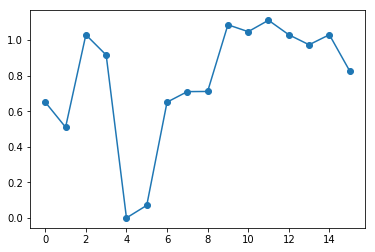

In [21]:
# Recuerde que las etiquetas de clase de las flechas las tenemos en un arreglo llamado y
print ("Etiquetas de los datos:\n", y)

# Calculamos el criterio de información mutua
mi = feature_selection.mutual_info_classif(X_scl, y)

# Visualizamos el valor de la métrica usando un gráfico de puntos
plt.figure(figsize=(6,4))
plt.plot(mi, 'o-')

¿Con base en este gráfico qué características escogería usted?

R/=

In [22]:
#Ahora empleemos la información mutua para hacer la selección
transformer = feature_selection.GenericUnivariateSelect(feature_selection.mutual_info_classif, 'k_best', param=5)

#Creamos la nueva matriz de características
X_new1 = transformer.fit_transform(X_scl, y)

#Obtenemos los índices de las características seleccionadas
idx = transformer.get_support(indices=True)

#Filtramos los nombres de las nuevas características
Xn_new1 = Xn[idx]

#¿Qué características nos quedan?
print("Características seleccionadas por análisis individual:", Xn_new1)

Características seleccionadas por análisis individual: ['m1' 'm2' 'm3' 'm4' 'm6']


### Selección recursiva de características 

Uno de los métodos de selección de características en esta categoría es el método de selección hacia atrás. Este método asigna un peso a cada característica (de acuerdo a alguna métrica como la precisión de clasificación) y va descartando, paso a paso, la característica menos importante. Este procedimiento se repite de forma recursiva hasta que finalmente se alcanza el número deseado de características para seleccionar.

Veamos como hacer esto en sklearn.


In [23]:
# En este caso, la métrica de selección es la precisión de clasificación usando una SVM lineal

# Creamos el clasificador
svc = svm.SVC(kernel="linear", C=1)

# Definimos el método de selección indicando que vamos a seleccionar 5 características
rfe = feature_selection.RFE(estimator=svc, n_features_to_select=5, step=1)

#Creamos la nueva matriz de características
X_new2 = rfe.fit_transform(X_scl, y)

# Visualizamos como quedaron organizadas las características.
# Aquellas con valor 1 son las seleccionadas
print ("Ranking de Caracteríticas: ", rfe.ranking_)

# Características seleccionadas
idx = rfe.get_support(indices=True)

#Filtramos los nombres de las nuevas características
Xn_new2 = Xn[idx]

#¿Qué características nos quedan?
print("Características seleccionadas por selección hacia atrás:", Xn_new2)

Ranking de Caracteríticas:  [12  9  2  1 11 10  8  6  5  1  1  1  1  4  3  7]
Características seleccionadas por selección hacia atrás: ['Excentricidad' 'm1' 'm2' 'm3' 'm4']


### Selección automática del número de características

Uno de los parámetros que se debe definir en el método anterior es el número de características a seleccionar. No obstante, el siguiente método (basado en selección hacia atrás) determina automáticamente (usando una validación cruzada) cuál es el número de características más adecuado para clasificar los datos.

Veamos cómo hacerlo:


Número óptimo de características: 2


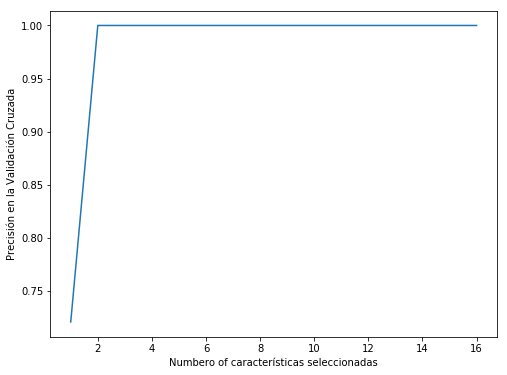

In [24]:
# Primero definimos el clasificador a usar en la selección automática
svc = svm.SVC(kernel="linear")

# En este caso usamos la precisión del clasificador como métrica de selección
# Así que aquí configuramos el selector automático
rfecv = feature_selection.RFECV(estimator=svc, step=1, 
                                cv=model_selection.StratifiedKFold(2), 
                                scoring='accuracy')

# Aplicamos el método de selección
X_new3 = rfecv.fit_transform(X_scl, y)

#Visualizamos el número óptimo de características a usar
print("Número óptimo de características: %d" % rfecv.n_features_)

# Veamos el gráfico de rendimiento del clasificador VS el número de características
plt.figure(figsize=(8,6))
plt.xlabel("Numbero of características seleccionadas")
plt.ylabel("Precisión en la Validación Cruzada")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Si usted examina el gráfico anterior, se dará cuenta que con 2 características es suficiente para clasificar correctamente todas las flechas, sin embargo, el método dice que se deben usar las 16.

## Usando las características para clasificar

El último paso consiste en entrenar un clasificador usando el conjunto de características que se seleccionaron. Entrenemos un clasificador fácil: una SVM con un kernel lineal (luego vemos en detalle que es esto).

Veamos el código:

Precisión del clasificador  1 :  0.6666666666666666
Precisión del clasificador  2 :  0.8666666666666667
Precisión del clasificador  3 :  0.7692307692307693
La precisión promedio obtenida es de:  0.7675213675213675


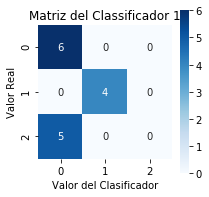

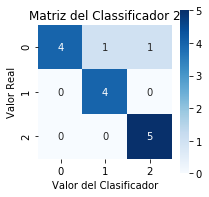

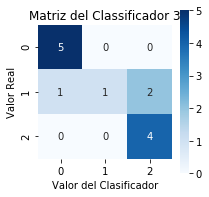

In [25]:
import seaborn as sns

# Como solo contamos con un conjunto de datos etiquetado es necesario que lo dividamos.
# Normalmente, se suele usar el 66.6% para entrenar y el 33.3% para probar el clasificador.
# Esta partición la hacemos con StratifiedKFold, el cual además nos permite entrenar con 2/3 y evaluar con 1/3, 3 veces
# A esto se le llama Validación Cruzada (CrossValidation con k=3) en Aprendizaje de Máquina.
cv = model_selection.StratifiedKFold(n_splits=3)

# Ahora definimos el clasificador a utilizar, en este caso una SVM con un kernel lineal
classifier = svm.SVC(kernel="linear")


#scores = model_selection.cross_val_score(classifier, X, y, cv=cv)
#print(scores) 

#scores = model_selection.cross_validate(classifier, X, y, cv=cv)
#print(scores) 

i = 1
suma = 0
# Cómo vamos a entrenar y validar 3 veces debemos hacerlo en un ciclo
for train_idx, test_idx in cv.split(X_new1, y):
    
    #Partimos el conjunto de datos
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
   
    # Entrenamos el clasificador
    classifier.fit(X_train, y_train)
    
    # Evaluamos el clasificador con los datos de prueba (test)
    y_predicted = classifier.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_predicted)
    suma += acc;
    print ("Precisión del clasificador ", i, ": ", acc)
    
    plt.figure(figsize=(3,3))
    plt.title('Matriz del Classificador '+str(i))
    
    # Creamos la matriz de confusión con las etiquetas reales y las predichas
    mat = metrics.confusion_matrix(y_test, y_predicted)

    # Mostramos la matriz de confusión como un mapa de calor
    sns.heatmap(mat, square=True, annot=True, cbar=True, cmap="Blues")

    # Agregamos los nombres de los ejes
    plt.xlabel('Valor del Clasificador')
    plt.ylabel('Valor Real');

    
    i += 1
    #print (metrics.classification_report(y_test, y_predicted))

print('La precisión promedio obtenida es de: ', (suma/3))
    
# Listo! Tenemos un clasificador entrenado

Las matrices de confusión nos permiten evaluar que tan buenos fueron los clasificadores entrenados con el conjunto de datos original partido en tres partes.  

# Entregables de la práctica

Tenga en cuenta que se evalúa calidad del entregable, las explicaciones dadas, la redacción, la ortografía, así como la calidad del código (si es entendible, limpio, ordenado, bien comentado y no ha solo sido copiado y pegado de lo realizado por el profe).

### Entregable 1: Clasificación sin selección de características

Para el desarrollo de esta práctica se entregan tres conjuntos de datos:

- Tortillas: que es un conjunto con tres clases (que hacen referencia a 3 calidades de tortillas mexicanas. El conjunto de datos tiene 300 muestras en total para las que se han extraído 1643 características.

- Rostros, es un conjunto de datos con dos clases (cara/no-cara). Este conjunto tiene 264 muestras en total con 1589 características.

- Género: este conjunto tiene 2 clases (female/male), con un total de 610 muestras, cada una con 1589 características calculadas

A Desarrollar para cada conjunto de datos:
1. Cargue los archivos de los conjuntos de datos adjuntos (los datos ya están normalizados)
2. Divida el conjunto de datos en 2 subconjuntos: un conjunto con el 80% de las muestras de cada clase para el  entrenamiento (training) y otro con el 20% restante como conjunto de pruebas (testing). Esto lo puede hacer manualmente o puede utilizar la función <span style="background-color:#DDDDDD; color:blue; font-family:Courier new">model_selection.train_test_split</span> para hacer la partición. Es necesario hacer esto y no copiar y pegar lo implementado en la práctica ya que en este caso sólo se entrenará un clasificador y usted NO hará Validación Cruzada.
3. Entrene un clasificador (puede ser la SVM lineal usada en esta práctica) o puede usar un clasificador como el clasificador de vecinos más cercanos, kNN (<span style="background-color:#DDDDDD; color:blue; font-family:Courier new">neighbors.KNeighborsClassifier</span> de `sklearn`). El clasificador debe ser entrenado con los datos de entrenamiento de la partición del punto anterior.
4. Use el conjunto de prueba para evaluar el clasificador: muestre la precisión del mismo y la matriz de confusión.


In [ ]:
# Aquí el código de este entregable

import scipy.io

#Punto 1: Conjunto de datos de las Tortillas
mat = scipy.io.loadmat('datos/set04-tortillas.mat')

y = mat['d'] # Etiquetas de clase de los objetos
X = mat['f'] # Matriz de datos: 300 objetos (filas) x 1643 características (columnas)
Xn = mat['fn'] # Nombres de las características

# Aquí ya puede continuar usted ...

### Entregable 2: Clasificación con selección de características

A Desarrollar para cada conjunto de datos de entrenamiento:
1. Elimine las características irrelevantes y llame al conjunto de datos resultante X_train_1
2. Aplique el método de selección hacia atrás (en la sección selección recursiva de características) y cree un nuevo conjunto de datos con 100 características (llame a este conjunto X_train_2).
3. Sobre el conjunto resultante en el punto anterior, aplique el algoritmo de selección automática hacia atrás (en la sección selección automática del número de características). Cuántas características son relevantes para el conjunto de datos?
4. A partir de la selección anterior cree un nuevo conjunto de datos y llámelo (X_train_3)
5. Haga un análisis individual de las características del conjunto de datos resultante del punto anterior y seleccione de él las 10 menores características (llame a este nuevo conjunto de datos X_train_4). Cuáles son los nombres de las características seleccionas en este último paso?
5. Con base en la selección de los pasos 1, 2, 4 y 5, genere los conjuntos de datos de prueba X_test_1, X_test_2, X_test_3 y X_test_4.
6. Por cada conjunto de datos X_train_*, entrene un clasificador (Del mismo tipo usado en el entregable 1) y evalúe el mismo con el conjunto de datos de prueba correspondiente. muestre la precisión del mismo y la matriz de confusión.

In [ ]:
# Aquí el código de este entregable


### Entregable 3: Análisis de los resultados obtenidos

1. Grafique las 2 mejores características obtenidas en la última selección usando un scatter. Qué tan buenas son para cada conjunto de datos?
2. Con base en las matrices de confusión y la precisión de los clasificadores, qué conclusiones puede sacar?

R/= Aquí su análisis